<a href="https://colab.research.google.com/github/ravi-gopalan/recsys/blob/master/Recommendations_with_IBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 



## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)



## Import Libraries

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import scipy.spatial.distance as dist
%matplotlib inline

In [5]:
# Clone the entire repo.
!git clone -l -s git://github.com/ravi-gopalan/recsys.git recsys-repo

%cd recsys-repo/
!ls

fatal: destination path 'recsys-repo' already exists and is not an empty directory.
/content/recsys-repo
articles_community.csv	README.md  user-item-interactions.csv


In [6]:
df = pd.read_csv('user-item-interactions.csv')
df_content = pd.read_csv('articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

df.head()
df.info()
df_content.head()
df_content.info()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [7]:
# Show df to get an idea of the data
df.head()
df.info()
df.describe(include='all')

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


,article_id,title,email
count,45993.000000,45993,45976
unique,NaN,714,5148
top,NaN,use deep learning for image classification,2b6c0f514c2f2b04ad3c4583407dccd0810469ee
freq,NaN,937,364
mean,908.846477,NaN,NaN
std,486.647866,NaN,NaN
min,0.000000,NaN,NaN
25%,460.000000,NaN,NaN
50%,1151.000000,NaN,NaN
75%,1336.000000,NaN,NaN


**df dataframe has ~46k records with 3 columns - email, article_id, and title**

In [8]:
# Show df_content to get an idea of the data
df_content.info()
df_content.head()
df_content.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


,doc_body,doc_description,doc_full_name,doc_status,article_id
count,1042,1053,1056,1056,1056.000000
unique,1036,1022,1051,1,NaN
top,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,Here’s this week’s news in Data Science and Bi...,Graph-based machine learning,Live,NaN
freq,4,16,2,1056,NaN
mean,NaN,NaN,NaN,NaN,523.913826
std,NaN,NaN,NaN,NaN,303.480641
min,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,260.750000
50%,NaN,NaN,NaN,NaN,523.500000
75%,NaN,NaN,NaN,NaN,786.250000


**doc_body DataFrame has 1056 rows and 5 columns - article_id, doc_full_name, doc_body, doc_description and doc_status**
* There are 1051 unique doc_full_name and all doc_status is Live
* Some doc_description and doc_body have missing values

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [12]:
user_article_count = df.groupby(by=['email'])['article_id'].count()
user_article_count
type(user_article_count)

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     2
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     4
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    32
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81    10
fffb93a166547448a0ff0232558118d59395fecd    13
Name: article_id, Length: 5148, dtype: int64

pandas.core.series.Series

In [14]:
print('Mean: {}'.format(user_article_count.mean()))
print('Median: {}'.format(user_article_count.median()))
print('STD: {}'.format(user_article_count.std()))
print('Min: {}'.format(user_article_count.min()))
print('Max: {}'.format(user_article_count.max()))



Mean: 8.930846930846931
Median: 3.0
STD: 16.802267126553936
Min: 1
Max: 364


* Most users have read 3 or lesser articles
* One user has read 364 articles
* The users have read atleast 1 article
* On average, a user has read 8.9 articles

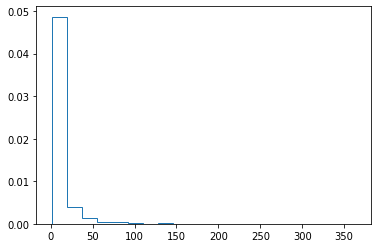

In [15]:
plt.hist(user_article_count,bins=20,histtype='step',density=True);

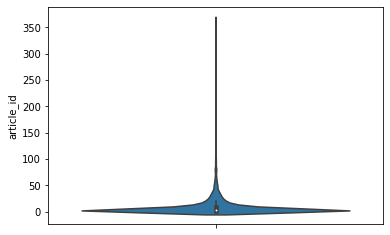

In [16]:
sns.violinplot(user_article_count,orient='v');

In [0]:
# Fill in the median and maximum number of user_article interactios below
# 50% of individuals interact with ____ number of articles or fewer.
median_val = user_article_count.median()
# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = user_article_count.max()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [18]:
# Find and explore duplicate articles
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(['article_id'],keep='first',inplace=True)
df_content.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1037 non-null object
doc_description    1048 non-null object
doc_full_name      1051 non-null object
doc_status         1051 non-null object
article_id         1051 non-null int64
dtypes: int64(1), object(4)
memory usage: 49.3+ KB


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [21]:
 

print(f'There are {df.article_id.nunique()} unique articles in df')
print(f'There are {df_content.article_id.nunique()} unique articles in df_content')
print(f'There are {df.email.nunique()} unique email accounts')



There are 714 unique articles in df
There are 1051 unique articles in df_content
There are 5148 unique email accounts


In [0]:
# The number of unique articles that have at least one interaction
unique_articles = df.groupby(by=['article_id'])['article_id'].count().sort_values(ascending=False).count()

# The number of unique articles on the IBM platform
total_articles = df_content.article_id.nunique()

# The number of unique users
unique_users = df.email.nunique()

# The number of user-article interactions
user_article_interactions = df.article_id.count()

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [0]:
# The most viewed article in the dataset as a string with one value following the decimal
most_viewed_article_id = str(pd.DataFrame(\
                                          np.array(df['article_id']\
                                                   .value_counts().index)).iloc[0][0] )
# The most viewed article in the dataset was viewed how many times?
max_views = pd.DataFrame(np.array(df['article_id'].value_counts())).iloc[0][0]

In [24]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [25]:
df.tail()

,article_id,title,user_id
45988,1324.0,ibm watson facebook posts for 2015,5146
45989,142.0,neural networks for beginners: popular types a...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148
45992,16.0,higher-order logistic regression for large dat...,5149


In [26]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}
sol_1_dict

{'`50% of individuals have _____ or fewer interactions.`': 3.0,
 '`The article_id of the most viewed article is ______.`': '1429.0',
 '`The maximum number of user-article interactions by any 1 user is ______.`': 364,
 '`The most viewed article in the dataset was viewed _____ times.`': 937,
 '`The number of unique articles on the IBM platform`': 1051,
 '`The number of unique articles that have at least 1 rating ______.`': 714,
 '`The number of unique users in the dataset is ______`': 5148,
 '`The total number of user-article interactions in the dataset is ______.`': 45993}

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [0]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    # Return the top article titles from df (not df_content)
    # Make a list of unique article_ids
    article_id_list = np.array(df['article_id'].value_counts().head(n).index)
    # article_id_list = np.array(df['article_id'].value_counts()[:n].index)
    # Remove duplicate articles
    df_articles=df[['article_id','title']].drop_duplicates()
    df_articles.set_index('article_id', inplace=True)
    
    # get the top articles as a list of the top 'n' articles in the list of  articles sorted by counts
    top_articles = list(df_articles.query('article_id in @article_id_list')['title'])
    

    
    return top_articles 

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_article_ids = list(df['article_id'].value_counts().head(n).index)
    # top_article_ids = list(df['article_id'].value_counts()[:n].index)
 
    return top_article_ids # Return the top article ids

In [28]:
print(get_top_articles(10))
print(get_top_article_ids(10))


['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [30]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

print(top_5, '\n',top_10, '\n',top_20)

['use deep learning for image classification', 'predicting churn with the spss random tree algorithm', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'insights from new york car accident reports'] 
 ['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization'] 
 ['healthcare python streaming application demo', 'use deep learning for image classification', 'classify tumors with machine learning', 'apache spark lab, part 1: basic concepts', 'the nurse assignment problem', 'predicting churn with the sp

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [31]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item.fillna(0, inplace=True)
    user_item[user_item > 0] = 1
    
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
user_item.shape
user_item

(5149, 714)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,20.0,25.0,26.0,28.0,29.0,30.0,32.0,33.0,34.0,36.0,39.0,40.0,43.0,48.0,50.0,51.0,53.0,54.0,57.0,58.0,59.0,60.0,62.0,64.0,65.0,68.0,74.0,76.0,77.0,78.0,...,1402.0,1403.0,1404.0,1405.0,1406.0,1407.0,1408.0,1409.0,1410.0,1411.0,1412.0,1414.0,1415.0,1416.0,1418.0,1419.0,1420.0,1421.0,1422.0,1423.0,1424.0,1425.0,1426.0,1427.0,1428.0,1429.0,1430.0,1431.0,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
pivot_df = df.copy()
pivot_df['val'] = 1
user_item = pivot_df.pivot_table(index='user_id', columns='article_id', values='val').fillna(0)
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,20.0,25.0,26.0,28.0,29.0,30.0,32.0,33.0,34.0,36.0,39.0,40.0,43.0,48.0,50.0,51.0,53.0,54.0,57.0,58.0,59.0,60.0,62.0,64.0,65.0,68.0,74.0,76.0,77.0,78.0,...,1402.0,1403.0,1404.0,1405.0,1406.0,1407.0,1408.0,1409.0,1410.0,1411.0,1412.0,1414.0,1415.0,1416.0,1418.0,1419.0,1420.0,1421.0,1422.0,1423.0,1424.0,1425.0,1426.0,1427.0,1428.0,1429.0,1430.0,1431.0,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
user_articles = df[['user_id', 'article_id']]
user_articles['interact_flag'] = 1
user_articles.shape


(45993, 3)

In [34]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [0]:
def create_similarity_matrices(matrix = user_item):
    '''
    INPUT:

    matrix - matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    calc_type - (string) - what method to use to calculate similarity            
    
    OUTPUT:
    4 similarity matrices (Euclidean, Manhattan,dot_product based and pivot) - (matrix) matrix of similarity which shows the similarity between the users 
    
    Description:
    Computes the similarity of every pair of users based on the similarity measure (euclidean, cityblock, dot_product)
    
    '''
        
    eucl_matrix = dist.squareform(dist.pdist(user_item, metric = 'euclidean'))
    manhat_matrix = dist.squareform(dist.pdist(user_item, metric = 'cityblock'))
    user_sim=np.dot(user_item,user_item.T)
    
    
    return eucl_matrix, manhat_matrix, user_sim

def create_users_and_articles_list(df = df):
    '''
    INPUT:

    df - dataframe of user, articles and titles            
    
    OUTPUT:
    users - array of unique users 
    articles - array of unique articles
    
    Description:
    Provides unique arrays for users and articles
    
    '''    
    
    users = np.unique(np.array(df.user_id))
    articles = np.unique(np.array(df.article_id))
    return users, articles

In [0]:
# Generate similarity matrices
eucl_matrix, manhat_matrix, user_sim = create_similarity_matrices(user_item)

# create unique user and article arrays
users, articles = create_users_and_articles_list(df)


In [37]:
user_sim.shape

(5149, 5149)

In [38]:
user_sim[0]

array([36.,  2.,  6., ...,  0.,  0.,  0.])

In [0]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    
    
    '''

    # compute similarity of each user to the provided user
    similarity = []
    for user in range(1, user_item.shape[0]+1):
        sim = np.dot(user_item.loc[1], user_item.loc[user])
        similarity.append((user, sim))
        
    # sort by similarity
    similarity.sort(key=lambda x: x[1], reverse=True)
    
    # create list of just the ids
    most_similar_users = [tup[0] for tup in similarity]
    
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar




In [40]:
print(find_similar_users(1)[:10]) 
print(find_similar_users(3933)[:10]) 
print(find_similar_users(46)[:10]) 
print(find_similar_users(131)[:10])

[3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
[1, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
[1, 3933, 23, 3782, 203, 4459, 131, 3870, 4201, 49]
[1, 3933, 23, 3782, 203, 4459, 3870, 46, 4201, 49]


In [41]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [1, 3933, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [0]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    df_articles=df[['article_id','title']].drop_duplicates()
    df_articles.set_index('article_id', inplace=True)
    article_names = list(df_articles.query('article_id in @article_ids')['title'])
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = list(user_item.columns[np.where(np.array(user_item)[user_id-1]>0)[0]])
    article_names = get_article_names(article_ids, df)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    # make a list of the user's articles
    user_article_ids, user_article_names =  get_user_articles(user_id, user_item)

    similar_users = find_similar_users(user_id)

    recs = np.array([])

    # find articles for each of those users
    
    for neighbor in similar_users:
        neighbor_article_ids, neighbor_article_names = get_user_articles(neighbor, user_item)

        new_recs = np.setdiff1d(neighbor_article_ids,user_article_ids,assume_unique=True)

        recs = np.unique(np.concatenate([new_recs, recs],axis=0))

    # create a running rec list - remove duplicates as long as the total recs <= number_required

        if len(recs) >= m:
            break

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
    
    return recs
    
#    return list(recs) # return your recommendations for this user_id    

In [43]:
# Check Results

print(get_article_names(user_user_recs(1, 10)[:10])) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium', 'timeseries data analysis of iot events by using jupyter notebook', 'graph-based machine learning', 'using brunel in ipython/jupyter notebooks', 'experience iot with coursera', 'the 3 kinds of context: machine learning and the art of the frame', 'deep forest: towards an alternative to deep neural networks', 'this week in data science (april 18, 2017)', 'higher-order logistic regression for large datasets', 'using machine learning to predict parking difficulty']


In [44]:
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set((['{:.1f}'.format(x) for x in get_user_articles(20)[0]])) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set((['{:.1f}'.format(x) for x in get_user_articles(2)[0]])) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [0]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Data Frame for interactions
    df_interactions = df.groupby(by=['user_id'])['article_id'].count()
    # create a dataframe for concatenating the interactions and the dot_product similarities
    interim_df = pd.concat([df_interactions, \
                            pd.DataFrame(user_sim[user_id-1,:],\
                                     columns=['similarity'])], axis=1)
    interim_df.rename(columns={'article_id':'num_interactions'}, inplace=True)
    interim_df.index.name = 'user_id'
    interim_df.reset_index(inplace=True)
    interim_df['user_id'] += 1
    neighbors_df = interim_df.sort_values(by=['similarity','num_interactions','user_id'],\
                                          ascending=[False,False,True])
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    temp_df = get_top_sorted_users(user_id, df, user_item)
    

    # make a list of the user's articles
    user_article_ids, user_article_names =  get_user_articles(user_id, user_item)

    # find similar users
    similar_users = np.array(temp_df.user_id)[1:]

    recs = np.array([])

    # find articles for each of those users
    
    for neighbor in similar_users:
        neighbor_article_ids, neighbor_article_names = get_user_articles(neighbor, user_item)

        new_recs = np.setdiff1d(neighbor_article_ids,user_article_ids,assume_unique=True)

        recs = np.unique(np.concatenate([new_recs, recs],axis=0))

    # create a running rec list - remove duplicates as long as the total recs <= 2*number_required

        if len(recs) >= 2*m:
            break
    # Find out the most popular articles
    col1 = pd.DataFrame(np.array(df['article_id'].value_counts().index))
    col2 = pd.DataFrame(np.array(df['article_id'].value_counts()))
    articles_sorted = pd.concat([col1,col2],\
                            axis=1)
    renamed_cols = ['article_id','article_interactions'] 
    articles_sorted.columns = renamed_cols
    
    # Find the most popular articles that the user hasnt interacted with
    recs = np.array(articles_sorted.query('article_id in @recs')['article_id'])


    
    rec_names = get_article_names(recs, df=df)
    return recs, rec_names

In [46]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids[:10])
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names[:10])

The top 10 recommendations for user 20 are the following article ids:
[1429. 1330. 1314. 1293. 1162. 1271.   43. 1351. 1368. 1305.]

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'use deep learning for image classification', 'ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'visualize data with the matplotlib library', 'got zip code data? prep it for analytics. – ibm watson data lab – medium', 'timeseries data analysis of iot events by using jupyter notebook', 'analyze energy consumption in buildings', 'analyze open data sets with pandas dataframes', 'intents & examples for ibm watson conversation']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [0]:
### Tests with a dictionary of results

user1_most_sim = np.array(get_top_sorted_users(1, \
                                               df=df, user_item=user_item)\
                          .head(2).tail(1).user_id)[0]# Find the user that is most similar to user 1 
user131_10th_sim = np.array(get_top_sorted_users(131, df=df, user_item=user_item)\
                            .head(11).tail(1).user_id)[0]# Find the 10th most similar user to user 131

In [48]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}
sol_5_dict
#t.sol_5_test(sol_5_dict)

{'The user that is most similar to user 1.': 3933,
 'The user that is the 10th most similar to user 131': 242}

`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**We can provide the articles that are the most popular and had the widest readership as choices for a completely new user**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [0]:
new_user = '0.0'

new_user_recs = list(np.array(pd.DataFrame(np.array(df['article_id'].value_counts().index)).head(10)).reshape(-1))

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_rec_names = get_article_names(new_user_recs, df=df)# Your recommendations here


new_user_recs = [str(i) for i in list(np.array(pd.DataFrame(np.array(df['article_id'].value_counts().index)).head(10)).reshape(-1))]


In [50]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.



In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

STOP = stopwords.words('english')
lemma = WordNetLemmatizer()

def my_tokenizer(s):
    s = s.lower() # downcase
    tokens = nltk.tokenize.word_tokenize(s) # split string into words (tokens)
    tokens = [t for t in tokens if len(t) > 2] # remove short words, they're probably not useful
    tokens = [lemma.lemmatize(t) for t in tokens] # put words into base form
    tokens = [t for t in tokens if t not in STOP] # remove stopwords
    return tokens


class ContentBasedRecommendations():
    def __init__(self, df_content):
        df_content['doc_body'] = df_content['doc_body'].fillna('')
        df_content['doc_description'] = df_content['doc_description'].fillna('')
        df_content['all_text'] = df_content['doc_full_name'] + ' ' + df_content['doc_body'] + ' ' + df_content['doc_description'] 
        self.df_content = df_content
        self.indices = pd.Series(df_content.index, index=df_content['doc_full_name']).drop_duplicates()

    def get_tfidf(self):
        # Compute tfidf 
        vect = TfidfVectorizer(stop_words='english')
        count_matrix = vect.fit_transform(self.df_content.all_text.values)
        return count_matrix

    def get_cosine_similarity_matrix(self, count_matrix):
        # Compute the cosine similarity matrix
        self.cosine_sim = linear_kernel(count_matrix, count_matrix)

    def get_recommendations_tfidf(self, name):
        if hasattr(self, 'cosine_sim'):
            # Get the index of the movie that matches the title
            idx = self.indices[name]
            # Get the pairwsie similarity scores of all movies with that movie
            sim_scores = list(enumerate(self.cosine_sim[idx]))
            # Sort the movies based on the similarity scores
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
            # Get the scores of the 10 most similar movies remove own
            print('getting recs')
            sim_scores = sim_scores[1:11]
            # Get the movie indices
            artcle_indices = [i[0] for i in sim_scores]
            # Return the top 10 most similar movies
            return df_content['doc_full_name'].iloc[artcle_indices]
        else:    
            print('building tfidf model')
            count_matrix = self.get_tfidf()
            self.get_cosine_similarity_matrix(count_matrix)
            return self.get_recommendations_tfidf(name)

    def tokenize(self, raw_text):
        all_tokens = []
        for text in raw_text:
            all_tokens.append(my_tokenizer(text))
        return all_tokens

    def build_doc2vec(self):
        all_tokens = self.tokenize(df_content.all_text.values)
        sentences = []
        for i, line in enumerate(all_tokens):
            sentences.append(TaggedDocument(line, [i]))

        self.model = Doc2Vec(documents=sentences)
        print('model built')

    def get_recommendations_doc2vec(self, name):
        if hasattr(self, 'model'):
            tokens = name.lower().split()
            new_vector = self.model.infer_vector(tokens)
            sims = self.model.docvecs.most_similar([new_vector])
            print('getting recs')
            recs = []
            for sim in sims:
                name = df_content.loc[df_content.article_id == sim[0], 'doc_full_name'].values[0]
                recs.append((name, round(sim[1], 2)))
            return recs
        else:
            print('building doc2vec model')
            self.build_doc2vec()
            return self.get_recommendations_doc2vec(name)


def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?



**Write an explanation of your content based recommendation system here.**

In [0]:
cb = ContentBasedRecommendations(df_content)

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.



In [53]:
# make recommendations for a brand new user

print(get_article_names([str(i) for i in list(df['article_id'].value_counts().index)][:10]))



# make a recommendations for a user who only has interacted with article id '1427.0'
print('recommendations for a user who only has interacted with article id 1427.0')
print(cb.get_recommendations_doc2vec(df[df.article_id == 1427.0].title.values[0]))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
recommendations for a user who only has interacted with article id 1427.0
building doc2vec model
model built
getting recs
[('DSX: Hybrid Mode', 0.57), ('Getting started with Apache Mahout', 0.54), ('Using BigDL in DSX for Deep Learning on Spark', 0.52), ('Pseudo-labeling a simple semi-supervised learning method', 0.5), ('Building Your First Machine Learning System ', 0.5), ('The Machine Learning Database', 0.5), ('Apache Spark™ 2.0: Extend Structured Streaming for Spark ML', 0.5), ('Using

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [54]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,20.0,25.0,26.0,28.0,29.0,30.0,32.0,33.0,34.0,36.0,39.0,40.0,43.0,48.0,50.0,51.0,53.0,54.0,57.0,58.0,59.0,60.0,62.0,64.0,65.0,68.0,74.0,76.0,77.0,78.0,...,1402.0,1403.0,1404.0,1405.0,1406.0,1407.0,1408.0,1409.0,1410.0,1411.0,1412.0,1414.0,1415.0,1416.0,1418.0,1419.0,1420.0,1421.0,1422.0,1423.0,1424.0,1425.0,1426.0,1427.0,1428.0,1429.0,1430.0,1431.0,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [0]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item, full_matrices=False)# use the built in to get the three matrices
#u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False)# use the built in to get the three matrices

**Since there are no missing values in the matrix and all values are either 0 or 1, the SVD can be performed as a closed-form solution without requiring iterations**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

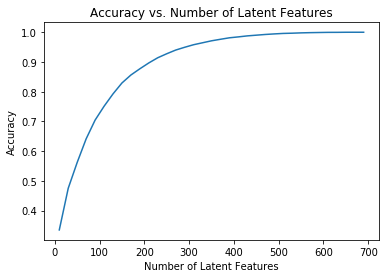

In [59]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [0]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    train_idx -  all of the user ids in the training set                
    test_idx - all of the user ids in the test set
    test_arts - all of the  article ids in the test set
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train) 
    user_item_test = create_user_item_matrix(df_test)
    
    # which rows can we use in test?
    train_idx = set(user_item_train.index)
    test_idx = set(user_item_test.index)
    match_idx = train_idx.intersection(test_idx)

    # which columns can we use in test?
    train_arts = set(user_item_train.columns)
    test_arts = set(user_item_test.columns)
    match_cols = train_arts.intersection(test_arts)
    
    user_item_test = user_item_test.loc[match_idx, match_cols]

    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [61]:
user_item_train.shape
user_item_test.shape

(4487, 714)

(20, 574)

In [63]:
# number of rows that are common between both train and test sets
print(user_item_test.shape[0])
# number of rows in the test that are not in the train set
print(user_item.shape[0] - user_item_train.shape[0])
# number of articles in the test set
print(user_item_test.shape[1])


20
662
574


In [65]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,# letter here, 
    'How many movies can we make predictions for in the test set?': b,# letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}
sol_4_dict
#t.sol_4_test(sol_4_dict)

{'How many movies can we make predictions for in the test set?': 574,
 'How many movies in the test set are we not able to make predictions for because of the cold start problem?': 0,
 'How many users can we make predictions for in the test set?': 20,
 'How many users in the test set are we not able to make predictions for because of the cold start problem?': 662}

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [66]:
# fit SVD on the user_item_train matrix
# fit svd similar to above then use the cells below
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)
u_train.shape, vt_train.shape, s_train.shape

((4487, 714), (714, 714), (714,))

In [67]:
u_train.shape

(4487, 714)

In [68]:
user_item_test.shape

(20, 574)

In [0]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data


In [69]:
# Find the user_ids and the article_ids that are common to both the train and test sets 
test_idx = np.array(user_item_test.index)

test_arts = np.array(user_item_test.columns)

len(test_idx), len(test_arts)

(20, 574)

In [70]:
# Find the indices of the user_ids and the article_ids for the dot product 
row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train.columns.isin(test_arts)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]
u_test.shape
vt_test.shape

(20, 714)

(714, 574)

In [0]:
# Find the indices of the user_ids and the article_ids for the dot product 
user_indices_test = np.array(user_item_train.index).searchsorted(test_idx)
articles_indices_test = np.array(user_item_train.columns).searchsorted(test_arts)

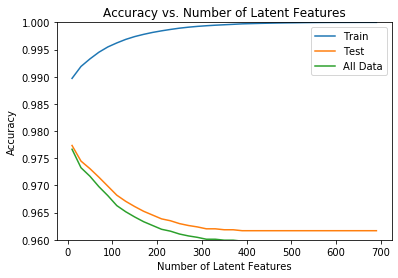

In [72]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_train = []
sum_errs_test = []
all_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))
    

    # compute error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test, user_item_test_preds)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_test.shape[1]), label='Train');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]), label='Test');
plt.plot(num_latent_feats, all_errs, label='All Data');
plt.ylim(0.96,1)
plt.legend()
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [73]:
# Print the first 20 error values for both the training and test sets as the number of latent factors increase
sum_errs_train[:20]
sum_errs_test[:20]

[26542.0,
 20886.0,
 17312.0,
 14149.0,
 11642.0,
 9745.0,
 8068.0,
 6735.0,
 5678.0,
 4767.0,
 4017.0,
 3350.0,
 2752.0,
 2285.0,
 1908.0,
 1603.0,
 1347.0,
 1137.0,
 931.0,
 703.0]

[260.0,
 293.0,
 309.0,
 327.0,
 346.0,
 365.0,
 378.0,
 389.0,
 399.0,
 407.0,
 415.0,
 419.0,
 425.0,
 429.0,
 432.0,
 436.0,
 436.0,
 438.0,
 438.0,
 440.0]

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

* The test accuracy is high overall, but as we increase the number of latent features, the accuracy decreases
* The test data has only 20 points which is actually a very small sample.
* If there is a way to increase the number of test samples, that would help. one could use a more random assigment of the train and test data sets to be able to get more than just 20 users in the test set
* We could setup multiple recommendation systems 'each with a different set of latent features' divide users into groups of test and control and perform A/B/C/D testing to see how the users react to the articles and see the result of these recommendations (test the number of different recommended articles that are reviewed by the users). That way we can determine the best recommendation system to use.

* In addition, one could use Natural Language Processing to mine the article titles to create a few broad categories to which these articles belong i.e. Pixiedust, Spark, Python, Image Classification, Scikit-Learn etc. and then rank the articles based on popularity and offer a knowledge-based recommendation option**
* When new articles are published, there needs to be a way to categorize them based on NLP and provide those as recommendations 

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!




In [0]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0